<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Exploration/Ex03/ablation_study_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 초기화 소스

In [14]:
!pip install torchinfo

In [20]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [22]:
# # Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
# transform = transforms.Compose([
#     transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
#     # 이미지 픽셀 값을 255로 나누어 0과 1 사이로 정규화하기 위해 transforms.ToTensor()를 사용한다.
# ])

In [33]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [24]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

## 데이터 로드 소스 from torchVision

In [39]:
trainset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True, target_types=["binary-category","category"], transform=hyperparams['transform'])
testset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True, target_types=["binary-category","category"], transform=hyperparams['transform'])

trainloader_2 = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader_2 = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# trainloader_2 = torch.utils.data.DataLoader(ds_split['train'], batch_size=32, shuffle=True)
# testloader_2 = torch.utils.data.DataLoader(ds_split['test'], batch_size=32, shuffle=False)
# validationloader_2 = torch.utils.data.DataLoader(ds_split['validation'], batch_size=32, shuffle=False)

100%|██████████| 792M/792M [00:30<00:00, 26.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.3MB/s]


## 이진 분류된 이미지의 결과를 확인

In [ ]:
def show_multiple_images_binary_label(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    # OxfordIIITPet 데이터셋의 이진 레이블에 대한 이름을 정의합니다.
    # 'binary-category'는 일반적으로 0:cat, 1:dog을 나타냅니다.
    binary_labels_map = ['cat', 'dog']

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)

        # labels는 (binary_labels_batch_tensor, category_labels_batch_tensor) 형태이므로
        # 첫 번째 텐서(binary_labels_batch_tensor)에서 i번째 항목을 가져옵니다.
        binary_label_idx = labels[0][i].item()

        # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
        if 0 <= binary_label_idx < len(binary_labels_map):
            label_text = binary_labels_map[binary_label_idx]
        else:
            label_text = f"Unknown (Index: {binary_label_idx})"

        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Trainloader_2 (Binary Labels):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.667763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53604114..1.8159112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43329263..1.7723382].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42473024..1.798482].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.6302402].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48038423..1.6154754].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531

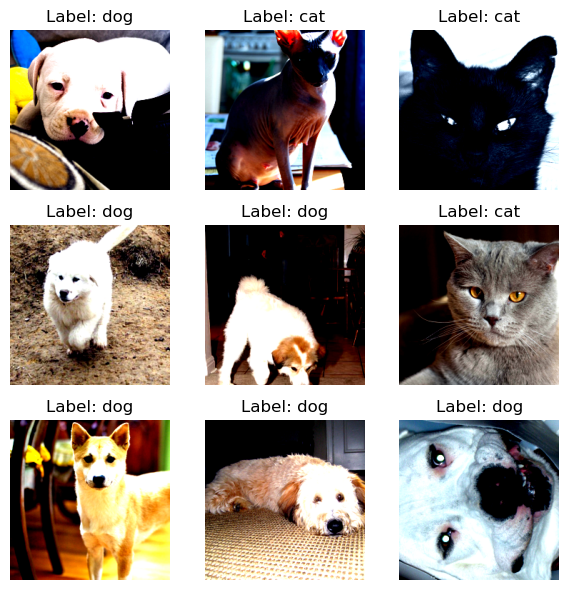


Testloader_2 (Binary Labels):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.8159112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.6503338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48038423..1.7079911].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5017916..1.8159112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42786324..1.8159112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4761045..1.6067607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531

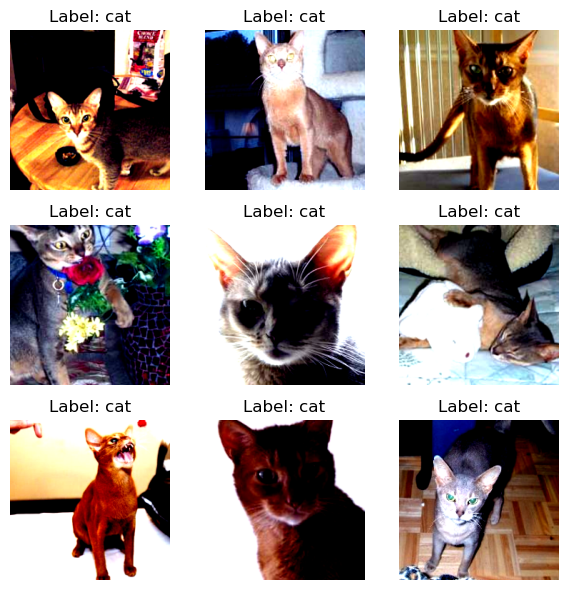

In [ ]:
# trainloader_2 에 대한 이진 레이블 시각화
print("Trainloader_2 (Binary Labels):")
show_multiple_images_binary_label(trainloader_2)

# testloader_2 에 대한 이진 레이블 시각화
print("\nTestloader_2 (Binary Labels):")
show_multiple_images_binary_label(testloader_2)

# ResNet 구현체

In [10]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [11]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [12]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [15]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 74.8MB/s]


21797672
21797672


## Build ResNet Code 생성

In [16]:

class build_resnet(nn.Module):
  def __init__(self, is_50, input_shape=(32,32,3), num_classes=1000):
    super().__init__()
    self._is_50 = is_50 # Store the parameter as an instance attribute
    self._input_shape = input_shape # Store input_shape for potential future use
    self._num_classes = num_classes # Store num_classes

    if self._is_50: # Use the instance attribute to determine the model type
      self.model = ResNet(BottleneckBlock, [3, 4, 6, 3], self._num_classes)
      self.block_type = BottleneckBlock
    else:
      self.model = ResNet(BasicBlock, [3, 4, 6, 3], self._num_classes)
      self.block_type = BasicBlock

  def forward(self, x):
    return self.model(x)

  def summary(self):
    # Use standard input size for ResNet summary, e.g., for ImageNet
    return summary(self.model, (1, 3, 224, 224), verbose=0)

In [17]:
# @title ResNet34 Summary
resnet_34_2 = build_resnet(is_50=False, input_shape=(32, 32,3), num_classes=2)
print(resnet_34_2.summary())

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-5                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│

In [ ]:
# @title ResNet50 Summary
resnet_50_2 = build_resnet(is_50=True, input_shape=(32, 32,3), num_classes=2)
print(resnet_50_2.summary())

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─BottleneckBlock: 2-5              [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│ 

In [18]:
# @title model 설정 : ResNet50
model = resnet_34_2

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [ ]:
# for epoch in range(hyperparams["epochs"]):
#     cost = 0.0

#     for images, classes in trainloader_2:
#         images = images.to(device)

#         # --- THE FIX ---
#         # classes is a list: [binary_targets, category_targets]
#         # 1. Select the second tensor (Index 1 is "category")
#         target_labels = classes[1]

#         # 2. Move ONLY that tensor to the device
#         target_labels = target_labels.to(device)
#         # ---------------

#         output = model(images)

#         # Ensure target is the correct shape/type for loss (usually Long)
#         # If your output is shape [32, 10], target_labels should be [32]
#         loss = criterion(output, target_labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         cost += loss.item() # .item() converts it to a simple float, freeing the GPU memory

#     cost = cost / len(trainloader_2)
#     print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}, Loss : {loss.item():.3f} ")

In [ ]:

# with torch.no_grad():
#     model.eval()

#     accuracy = 0.0
#     for images, classes in testloader_2:
#         images = images.to(device)
#         classes = classes[1].to(device)

#         outputs = model(images)
#         probs = F.softmax(outputs, dim=-1)
#         outputs_classes = torch.argmax(probs, dim=-1)

#         accuracy += int(torch.eq(classes, outputs_classes).sum())

#     print(f"acc@1 : {accuracy / (len(testloader_2) * hyperparams['batch_size']) * 100:.2f}%")

In [34]:
def show_multiple_images_binary_label(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    # OxfordIIITPet 데이터셋의 이진 레이블에 대한 이름을 정의합니다.

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)

        # labels는 (binary_labels_batch_tensor, category_labels_batch_tensor) 형태이므로
        # 첫 번째 텐서(binary_labels_batch_tensor)에서 i번째 항목을 가져옵니다.

        binary_label_idx = labels[0][i].item()

        # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
        if 0 <= binary_label_idx < len(binary_labels_map):
            label_text = binary_labels_map[binary_label_idx]
        else:
            label_text = f"Unknown (Index: {binary_label_idx})"

        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 'binary-category'는 일반적으로 0:cat, 1:dog을 나타냅니다.
binary_labels_map = ['cat', 'dog']
def display_predictions_binary_label(loader, model, class_names, device, n_images=9):
    dataiter = iter(loader)
    images, labels = next(dataiter) # Get a batch of images and labels

    fig, axes = plt.subplots(3, 3, figsize=(8, 8)) # Create a 3x3 grid for images
    axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

    with torch.no_grad(): # Disable gradient calculation for inference
        for i in range(n_images):
            if i >= len(images): # Ensure we don't go out of bounds if batch size is smaller than n_images
                break

            ax = axes[i]
            img = imshow(images[i]) # Use the helper function to properly display the image
            ax.imshow(img)

            # Get model output for the image
            outputs = model(images[i].unsqueeze(0).to(device)) # Add batch dimension and move to device

            # Get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Get the class names
            predicted_class_name = class_names[predicted[0]]
            # print(predicted_class_name)

            binary_label_idx = labels[0][i].item()
            # true_class_name = class_names[labels[i]]

            # Set the title with true and predicted labels
            # 인덱스가 유효한 범위 내에 있는지 확인하고, 아니면 'Unknown'으로 처리합니다.
            if 0 <= binary_label_idx < len(binary_labels_map):
                label_text = binary_labels_map[binary_label_idx]
            else:
                label_text = f"Unknown (Index: {binary_label_idx})"

            ax.set_title(f"True: {label_text}, Label: {predicted_class_name}")
            # ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}", fontsize=10)
            ax.axis('off') # Hide axes ticks

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show() # Display the plot


In [35]:
class_names = ['cat', 'dog']

In [ ]:
# for epoch in range(hyperparams["epochs"]):
#     cost = 0.0

#     for images, classes in trainloader_2:
#         images = images.to(device)
#         classes = classes.to(device)

#         output = model(images)
#         loss = criterion(output, classes)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         cost += loss

#     cost = cost / len(trainloader_2)
#     print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")
#     # print('Epoch %s: Train Accuracy: %.2f percent, Validation Accuracy: %.2f percent, Train Loss: %s, Validation Loss: %s'
#     #       % (epoch, train_acc, val_acc, train_loss, val_loss))

In [ ]:

# with torch.no_grad():
#     model.eval()

#     accuracy = 0.0
#     for images, classes in testloader_2:
#         images = images.to(device)
#         classes = classes.to(device)

#         outputs = model(images)
#         probs = F.softmax(outputs, dim=-1)
#         outputs_classes = torch.argmax(probs, dim=-1)

#         accuracy += int(torch.eq(classes, outputs_classes).sum())

#     print(f"acc@1 : {accuracy / (len(testloader_2) * hyperparams['batch_size']) * 100:.2f}%")

In [ ]:
# def display_predictions(loader, model, class_names, device, n_images=9):
#     dataiter = iter(loader)
#     images, labels = next(dataiter) # Get a batch of images and labels

#     fig, axes = plt.subplots(3, 3, figsize=(8, 8)) # Create a 3x3 grid for images
#     axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

#     with torch.no_grad(): # Disable gradient calculation for inference
#         for i in range(n_images):
#             if i >= len(images): # Ensure we don't go out of bounds if batch size is smaller than n_images
#                 break

#             ax = axes[i]
#             img = imshow(images[i]) # Use the helper function to properly display the image
#             ax.imshow(img)

#             # Get model output for the image
#             outputs = model(images[i].unsqueeze(0).to(device)) # Add batch dimension and move to device

#             # Get predicted class
#             _, predicted = torch.max(outputs.data, 1)

#             # Get the class names
#             predicted_class_name = class_names[predicted.item()]
#             true_class_name = class_names[labels[i]]

#             # Set the title with true and predicted labels
#             ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}", fontsize=10)
#             ax.axis('off') # Hide axes ticks

#     plt.tight_layout() # Adjust subplot parameters for a tight layout
#     plt.show() # Display the plot


In [ ]:

# display_predictions(trainloader_2, model, class_names, device)
# display_predictions(testloader_2, model, class_names, device)

# ResNet-34, ResNet-50 각각 plain모델과 residual모델

In [ ]:
import torch
import torch.nn as nn

class PlainBlock(nn.Module):
    """
    ResNet의 BasicBlock과 구조는 같지만,
    Skip Connection(+ identity)이 없는 블록
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()

        # 첫 번째 Conv (Stride가 1이 아닐 수도 있음)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 Conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 1. Convolution 통과
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # [차이점] 여기서 ResNet은 'out += x'를 하지만, Plain 모델은 하지 않습니다.

        out = self.relu(out)
        return out


In [26]:
def build_plainnet(is_50=False, input_shape=(32, 32, 3), num_classes=2):
    """
    ResNet-34와 동일한 층 수를 가지지만,
    Skip Connection이 없는 PlainNet-34 모델을 생성합니다.
    """

    # ResNet-34와 동일한 레이어 구성
    layers = [3, 4, 6, 3]

    # 블록 타입으로 BasicBlock 대신 PlainBlock을 사용
    # is_50(Bottleneck) 옵션은 PlainNet 실험에서 보통 34층 이하를 비교하므로 무시하거나 False로 둠
    model = ResNet(PlainBlock, layers, num_classes=num_classes)

    return model

In [30]:
plainnet_34_2 = build_plainnet(is_50=False, input_shape=(32, 32,3), num_classes=2)
print(summary(plainnet_34_2))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─PlainBlock: 2-5                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─PlainBlock: 2-6                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
│    └─PlainBlock: 2-7                   --
│    │    └─Conv2d: 3-11                 36,864

In [29]:
plainnet_50_2 = build_plainnet(is_50=True, input_shape=(32, 32,3), num_classes=2)
print(summary(plainnet_50_2))


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─PlainBlock: 2-5                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─PlainBlock: 2-6                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
│    └─PlainBlock: 2-7                   --
│    │    └─Conv2d: 3-11                 36,864

In [36]:
BATCH_SIZE = 256
EPOCH = 15

Training on device: cuda
[1,   100] Step Loss: 0.647
Epoch 1 Finished. Avg Loss: 0.6450, Train Acc: 65.73%
Epoch 1: Validation Accuracy: 67.97%
--------------------
[2,   100] Step Loss: 0.603
Epoch 2 Finished. Avg Loss: 0.5998, Train Acc: 67.96%
Epoch 2: Validation Accuracy: 68.55%
--------------------
[3,   100] Step Loss: 0.558
Epoch 3 Finished. Avg Loss: 0.5582, Train Acc: 70.27%
Epoch 3: Validation Accuracy: 70.05%
--------------------
[4,   100] Step Loss: 0.526
Epoch 4 Finished. Avg Loss: 0.5256, Train Acc: 72.93%
Epoch 4: Validation Accuracy: 70.54%
--------------------
[5,   100] Step Loss: 0.472
Epoch 5 Finished. Avg Loss: 0.4799, Train Acc: 76.93%
Epoch 5: Validation Accuracy: 50.42%
--------------------
[6,   100] Step Loss: 0.423
Epoch 6 Finished. Avg Loss: 0.4303, Train Acc: 79.78%
Epoch 6: Validation Accuracy: 73.73%
--------------------
[7,   100] Step Loss: 0.346
Epoch 7 Finished. Avg Loss: 0.3522, Train Acc: 84.16%
Epoch 7: Validation Accuracy: 74.68%
----------------

In [37]:

import time
import torch
import torch.nn as nn
import torch.optim as optim
def model_run_epoch_classnet(origin_model):
  # 1. 초기 설정
  current_time = time.time()
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = origin_model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

  optimizer = optim.SGD(origin_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

  origin_model_train_losses = []
  origin_model_val_accuracy = []

  print(f"Training on device: {device}")

  for epoch in range(EPOCH):
      resnet_34_2.train()

      running_loss = 0.0      # 100 배치마다 출력용
      epoch_loss = 0.0        # 전체 Epoch 평균 계산용 (추가됨)
      correct = 0
      total = 0

      for i, (inputs, labels) in enumerate(trainloader_2, 0):
          # inputs: 이미지, labels: [binary_label, breed_label] 리스트
          # labels[0]이 Cat/Dog 이진 라벨입니다.
          inputs = inputs.to(device)
          targets = labels[0].to(device).long() # .long()은 정수형 변환 (필수)

          optimizer.zero_grad()
          outputs = resnet_34_2(inputs)

          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

          # Loss 누적
          loss_val = loss.item()
          running_loss += loss_val
          epoch_loss += loss_val

          # 정확도 계산
          _, predicted = torch.max(outputs, 1)
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

          # 100 미니배치마다 로그 출력
          if i % 100 == 99:
              print(f"[{epoch + 1}, {i + 1:5d}] Step Loss: {running_loss / 100:.3f}")
              running_loss = 0.0 # 출력용 변수만 초기화

      # --- [수정 2] 정확한 Epoch Loss 계산 ---
      # running_loss는 중간에 0으로 초기화되므로, 별도의 epoch_loss 변수를 사용해야 정확합니다.
      avg_train_loss = epoch_loss / len(trainloader_2)
      train_acc = 100 * correct / total

      origin_model_train_losses.append(avg_train_loss)
      print(f"Epoch {epoch + 1} Finished. Avg Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

      # --- Validation Loop (검증) ---
      resnet_34_2.eval()
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for inputs, labels in testloader_2:
              inputs = inputs.to(device)
              targets = labels[0].to(device).long() # 검증 때도 labels[0] 사용

              outputs = resnet_34_2(inputs)
              _, predicted = torch.max(outputs, 1)

              val_total += targets.size(0)
              val_correct += (predicted == targets).sum().item()

      val_acc = 100 * val_correct / val_total
      origin_model_val_accuracy.append(val_acc)

      print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")
      print("-" * 20)

  print("Finished Training")
  print(f"Time elapsed: {time.time() - current_time:.2f} seconds")
  return origin_model_train_losses, origin_model_val_accuracy

In [ ]:
l34,a34 = model_run_epoch_classnet(resnet_34_2)

Training on device: cpu


In [ ]:
l50,a50 = model_run_epoch_classnet(resnet_50_2)

In [ ]:
lp34,ap34 = model_run_epoch_classnet(plainnet_34_2)

In [ ]:
lp50,ap50 = model_run_epoch_classnet(plainnet_50_2)

In [ ]:
import torch
import torch.nn as nn
# Re-import your libraries/functions here if needed
# form your_script import trainloader_2, build_resnet

# 1. Define Model on CPU (Do NOT .to(device) yet)
# Ensure this matches your training attempt (num_classes=2)
model_test = build_resnet(is_50=False, input_shape=(32, 32, 3), num_classes=2)

# 2. Get one batch of data
dataiter = iter(trainloader_2)
inputs, labels = next(dataiter)

# 3. Simulate the logic you used in your loop
# You used: labels[0]
target_labels = labels[0]

print(f"--- DIAGNOSTIC REPORT ---")
print(f"1. Model Output Size: {model_test(inputs).shape[1]}")
print(f"2. Target Shape:      {target_labels.shape}")
print(f"3. Target Min Value:  {target_labels.min().item()}")
print(f"4. Target Max Value:  {target_labels.max().item()}")

# 4. Check for the Crash Trigger
num_classes = model_test(inputs).shape[1]
max_label = target_labels.max().item()

if max_label >= num_classes:
    print(f"\n❌ CRASH CAUSE FOUND: Max label is {max_label}, but model only has {num_classes} outputs.")
    print(f"   (Indices must be between 0 and {num_classes-1})")
    print("   -> SOLUTION: You are likely using the wrong label index, or need num_classes=37.")
else:
    print(f"\n✅ Safe to train: Labels (0-{max_label}) fit inside Model (0-{num_classes-1}).")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.7200506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4761045..1.357851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48038423..1.62419].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5274788..1.6764776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5531659..1.4589927].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40760553..1.6503338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5446036

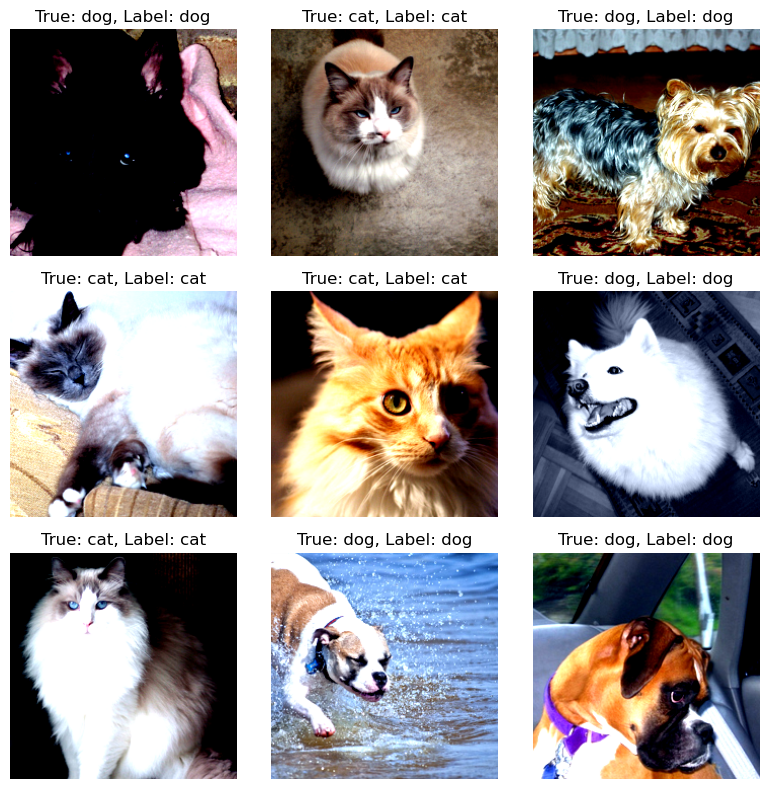

In [ ]:
class_names = binary_labels_map
display_predictions_binary_label(trainloader_2, model, class_names, device, n_images=9)